# Tracking the Growth of COVID-19 Cases in Japan

### データソース  
以下のダッシュボードのgithubで公開されているcsvを使用してます。

* 新型コロナウイルス感染速報  
https://covid-2019.live/

* csv  
https://raw.githubusercontent.com/swsoyee/2019-ncov-japan/master/Data/byDate.csv

In [1]:
# Now
! date

2020年  4月 14日 火曜日 19:05:25 JST


In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from termcolor import colored, cprint

import plotly.graph_objects as go
#import plotly.offline as offline
#offline.init_notebook_mode(connected=True)

from matplotlib.dates import DateFormatter
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook  # If you switch from inline to notebook, you must restart the kernel!

#matplotlibで日本語フォントを使う設定
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']


# データ・セット

In [3]:
# csv読み込み
df_raw = pd.read_csv( 'https://raw.githubusercontent.com/swsoyee/2019-ncov-japan/master/Data/byDate.csv')

# 全部 Nanの行は削除
if( df_raw.iloc[-1:,1:].isnull().all(axis=1).values[0] == True ):
    df_raw = df_raw.drop(df_raw.index.values[-1])
    print('drop [.isnull().all()] record')

# 日付に変換
df_raw['date'] = pd.to_datetime(df_raw['date'], format='%Y%m%d')
days = df_raw['date'].dt.strftime('%m/%d/%y').values.tolist()

# 欠損値を0にする
df_raw = df_raw.fillna(0)

# 増加数と日本全体(クルーズ船とチャーター便を除く)
inc = df_raw
inc['日本全体'] = inc.drop(columns=['クルーズ船','チャーター便']).iloc[:,1:].sum(axis=1)

# 累積数を出す
tot = pd.concat( [inc.iloc[:,0:1], inc.iloc[:,1:].cumsum()], axis=1)

# 流用元(global版)と同じ構成になるよう
tmp = tot.set_index('date').T.reset_index()
tmp.columns.name = None
tmp = tmp.rename(columns={'index':'Country/Region'})
tmp['Province/State'] = np.nan
tmp['Lat'] = np.nan
tmp['Long'] = np.nan
df = pd.concat([tmp[['Province/State', 'Country/Region', 'Lat', 'Long']], tmp.iloc[:, 1:-3]], axis=1)
df.columns = df.columns[0:4].values.tolist() + days

In [4]:
 df.head()

,Province/State,Country/Region,Lat,Long,01/15/20,01/16/20,01/17/20,01/18/20,01/19/20,01/20/20,...,04/05/20,04/06/20,04/07/20,04/08/20,04/09/20,04/10/20,04/11/20,04/12/20,04/13/20,04/14/20
0,NaN,北海道,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,191.0,191.0,195.0,205.0,223.0,236.0,252.0,264.0,269.0,287.0
1,NaN,青森,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,11.0,12.0,12.0,14.0,17.0,22.0,22.0,22.0,22.0
2,NaN,岩手,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,宮城,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,23.0,26.0,32.0,34.0,36.0,38.0,45.0,51.0,54.0,56.0
4,NaN,秋田,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,11.0,11.0,11.0,11.0,13.0,15.0,15.0,15.0,16.0


In [5]:
df.head()

,Province/State,Country/Region,Lat,Long,01/15/20,01/16/20,01/17/20,01/18/20,01/19/20,01/20/20,...,04/05/20,04/06/20,04/07/20,04/08/20,04/09/20,04/10/20,04/11/20,04/12/20,04/13/20,04/14/20
0,NaN,北海道,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,191.0,191.0,195.0,205.0,223.0,236.0,252.0,264.0,269.0,287.0
1,NaN,青森,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,11.0,12.0,12.0,14.0,17.0,22.0,22.0,22.0,22.0
2,NaN,岩手,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,宮城,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,23.0,26.0,32.0,34.0,36.0,38.0,45.0,51.0,54.0,56.0
4,NaN,秋田,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,11.0,11.0,11.0,11.0,13.0,15.0,15.0,15.0,16.0


## COVID-19 Analysis

In [6]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
#cases = cases[cases[mostrecentdate] >= 100]
cases = cases[cases[mostrecentdate] >= 20]
cases.head()


Total number of cases (in countries with at least 100 cases) as of 04/14/20


,04/14/20
Country/Region,
日本全体,8009.0
東京,2319.0
大阪,835.0
クルーズ船,712.0
神奈川,579.0


## Curve Fitting Global COVID-19 Cases

In [7]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country, maxfev=100000, use_plotly=False):
#def plotCases(dataframe, column, country, maxfev=1):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    if(use_plotly is False):
        plt.figure(figsize=(10,5))
        plt.plot(x, y, 'ko', label="Original Data")
    else:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=x, y=y, mode='markers', name='Original Data'))
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=maxfev)
        lerror = np.sqrt(np.diag(lpcov))

        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])

        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  

        if logisticr2 > 0.95:
            if(use_plotly is False):
                plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            else:
                fig.add_trace(go.Scatter(x=x, y=logistic(x, *lpopt), mode='lines', line=dict(dash='dot'), name="Logistic Curve Fit") )
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            print("\tparam: ", lpopt)
            logisticworked = True
        else:
            print("\n logistic R^2 ", logisticr2)    
    except Exception as ex:
        cprint('\nException in logstic process ', 'red')
        cprint(type(ex), 'red')
        cprint(ex, 'red')
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=maxfev)
        eerror = np.sqrt(np.diag(epcov))

        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])

        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)

        if expr2 > 0.95:
            if(use_plotly is False):
                plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            else:
                fig.add_trace(go.Scatter(x=x, y=exponential(x, *epopt), mode='lines', line=dict(dash='dot'), name="Exponential Curve Fit"))
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            print("\tparam: ", epopt)
            exponentialworked = True
        else:
            print("\n exponential R^2 ", expr2)    
    except Exception as ex:
        cprint('\nException in exponential process ', 'red')
        cprint(type(ex), 'red')
        cprint(ex, 'red')
    
    if(use_plotly == False):
        plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
        plt.xlabel('Days', fontsize="x-large")
        plt.ylabel('Total Cases', fontsize="x-large")
        plt.legend(fontsize="x-large")
        plt.show()
    else:
        fig.update_layout(title=country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')'
                          ,  xaxis_title='Days'
                          , yaxis_title='Total Cases'
                          , width=900, height=700,  autosize=False
                          #,paper_bgcolor='black'
                         )
        fig.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



日本全体

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 8009.0
	Confirmed cases on 04/07/20 	 4439.0
	Ratio: 1.8
	Weekly increase: 80.4 %
	Daily increase: 8.8 % per day
	Doubling Time (represents recent growth): 8.2 days

** Based on Logistic Fit**

	R^2: 0.9958873756629646
	Doubling Time (during middle of growth):  15.4 (± 0.87 ) days
	param:  [2.06920160e+10 9.00150250e-02 3.85495754e+01 5.28012974e+10]

** Based on Exponential Fit **

	R^2: 0.9958873757343499
	Doubling Time (represents overall growth):  7.7 (± 0.22 ) days
	param:  [ 2.55177367  0.09001501 38.54956331]


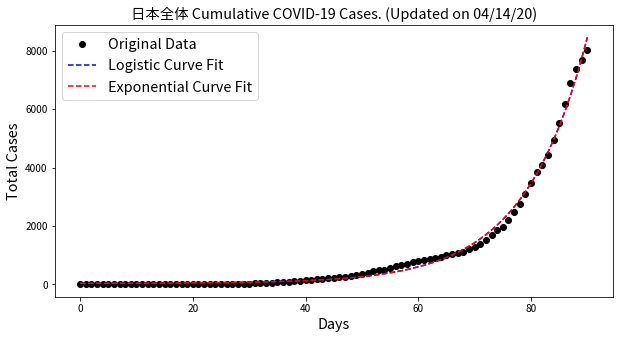



東京

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 2319.0
	Confirmed cases on 04/07/20 	 1194.0
	Ratio: 1.94
	Weekly increase: 94.2 %
	Daily increase: 9.9 % per day
	Doubling Time (represents recent growth): 7.3 days

** Based on Logistic Fit**

	R^2: 0.9986065784702373
	Doubling Time (during middle of growth):  8.93 (± 0.41 ) days
	param:  [2.48959781e+05 1.55273110e-01 2.00719487e+01 4.35223215e+03]

** Based on Exponential Fit **

	R^2: 0.9948575402622414
	Doubling Time (represents overall growth):  6.42 (± 0.21 ) days
	param:  [0.39711087 0.10794029 0.53493993]


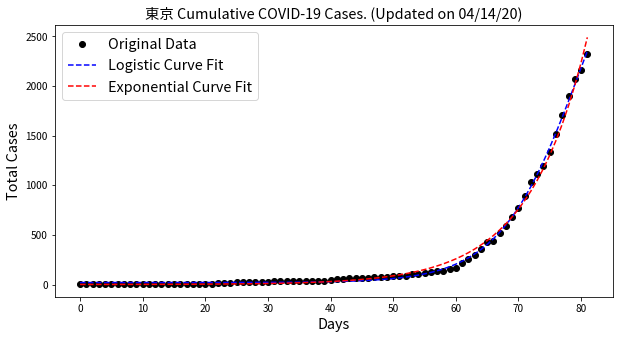



大阪

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 835.0
	Confirmed cases on 04/07/20 	 481.0
	Ratio: 1.74
	Weekly increase: 73.6 %
	Daily increase: 8.2 % per day
	Doubling Time (represents recent growth): 8.8 days

** Based on Logistic Fit**

	R^2: 0.9905631472066337
	Doubling Time (during middle of growth):  16.21 (± 2.54 ) days
	param:  [ 1.72707339e+09  8.55346799e-02 -1.02845028e+00  2.35775006e+09]

** Based on Exponential Fit **

	R^2: 0.9905631476118121
	Doubling Time (represents overall growth):  8.1 (± 0.4 ) days
	param:  [ 1.36517216  0.08553466 -1.02846215]


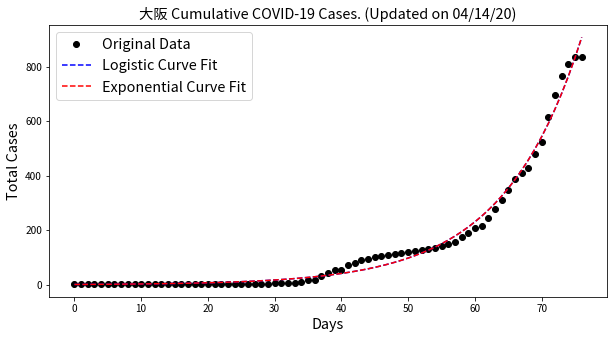



クルーズ船

** Based on Logistic Fit**

	R^2: 0.9951689286197526
	Doubling Time (during middle of growth):  3.22 (± 0.27 ) days
	param:  [1.03580442e+02 4.30072463e-01 3.88175171e+01 7.08065421e+02]

 exponential R^2  -0.3349717671894188


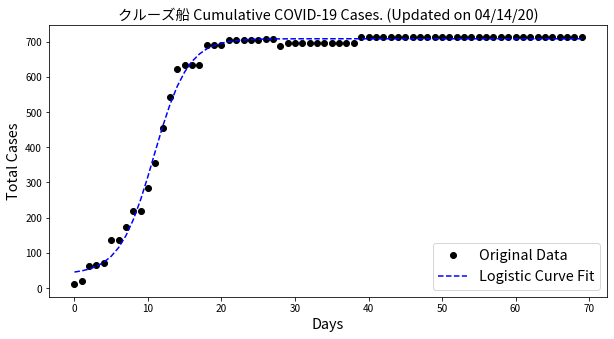



神奈川

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 579.0
	Confirmed cases on 04/07/20 	 289.0
	Ratio: 2.0
	Weekly increase: 100.3 %
	Daily increase: 10.4 % per day
	Doubling Time (represents recent growth): 7.0 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.9914768894707625
	Doubling Time (represents overall growth):  7.14 (± 0.29 ) days
	param:  [0.09806346 0.09706611 7.1685761 ]


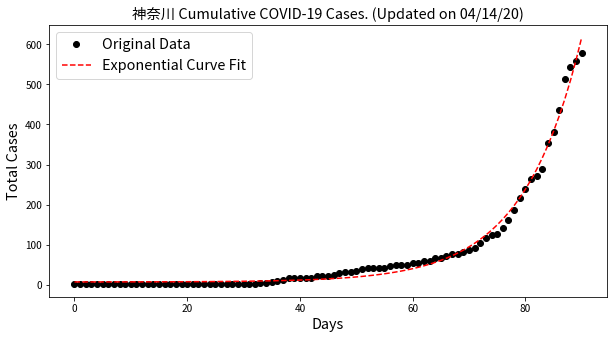



千葉

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 502.0
	Confirmed cases on 04/07/20 	 291.0
	Ratio: 1.73
	Weekly increase: 72.5 %
	Daily increase: 8.1 % per day
	Doubling Time (represents recent growth): 8.9 days

** Based on Logistic Fit**

	R^2: 0.9938531686247997
	Doubling Time (during middle of growth):  9.98 (± 1.0 ) days
	param:  [1.99662216e+04 1.38865851e-01 6.32374860e+00 8.54256808e+02]

** Based on Exponential Fit **

	R^2: 0.989100111422623
	Doubling Time (represents overall growth):  7.64 (± 0.4 ) days
	param:  [ 0.65965901  0.09076718 -0.86344073]


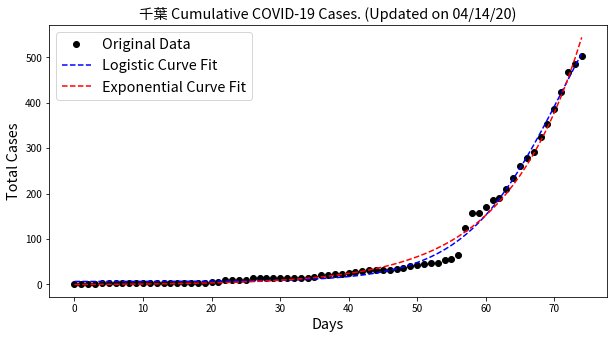



埼玉

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 435.0
	Confirmed cases on 04/07/20 	 216.0
	Ratio: 2.01
	Weekly increase: 101.4 %
	Daily increase: 10.5 % per day
	Doubling Time (represents recent growth): 6.9 days

** Based on Logistic Fit**

	R^2: 0.9923564121973392
	Doubling Time (during middle of growth):  11.57 (± 1.95 ) days
	param:  [2.28642083e+03 1.19858023e-01 3.27234946e+00 2.32681228e+03]

** Based on Exponential Fit **

	R^2: 0.9920616952583357
	Doubling Time (represents overall growth):  6.59 (± 0.37 ) days
	param:  [1.79819726 0.10524237 0.03496139]


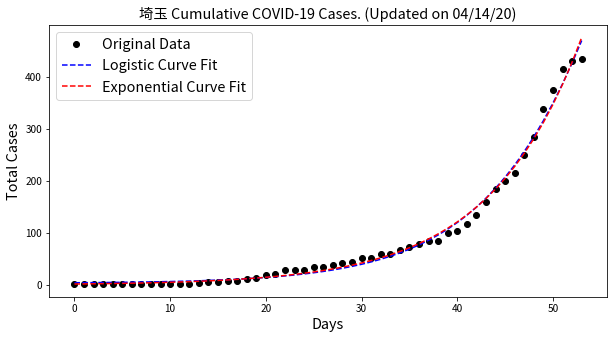



兵庫

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 402.0
	Confirmed cases on 04/07/20 	 229.0
	Ratio: 1.76
	Weekly increase: 75.5 %
	Daily increase: 8.4 % per day
	Doubling Time (represents recent growth): 8.6 days

** Based on Logistic Fit**

	R^2: 0.9729371915160845
	Doubling Time (during middle of growth):  22.93 (± nan ) days
	param:  [ 1.16229403e+08  6.04694633e-02 -1.47592188e+01  3.34010536e+09]

** Based on Exponential Fit **

	R^2: 0.9729371929627834
	Doubling Time (represents overall growth):  11.46 (± 1.93 ) days
	param:  [ 28.73675267   0.06046978 -14.75851613]


/home/ma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning:

invalid value encountered in sqrt



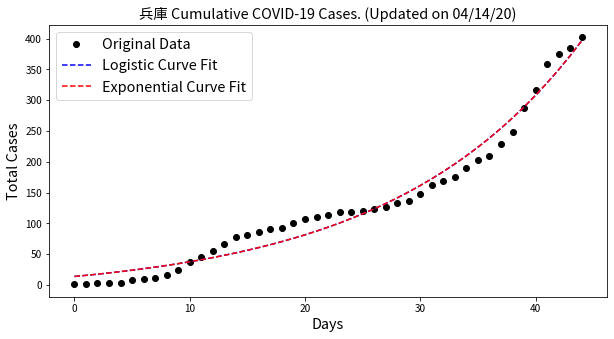



福岡

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 389.0
	Confirmed cases on 04/07/20 	 199.0
	Ratio: 1.95
	Weekly increase: 95.5 %
	Daily increase: 10.0 % per day
	Doubling Time (represents recent growth): 7.2 days

** Based on Logistic Fit**

	R^2: 0.9962497872593804
	Doubling Time (during middle of growth):  5.57 (± 0.47 ) days
	param:  [1.62585775e+05 2.48882282e-01 1.10683286e+00 4.84677749e+02]

** Based on Exponential Fit **

	R^2: 0.9785762506966155
	Doubling Time (represents overall growth):  5.62 (± 0.49 ) days
	param:  [ 0.57569713  0.12328263 -7.07781286]


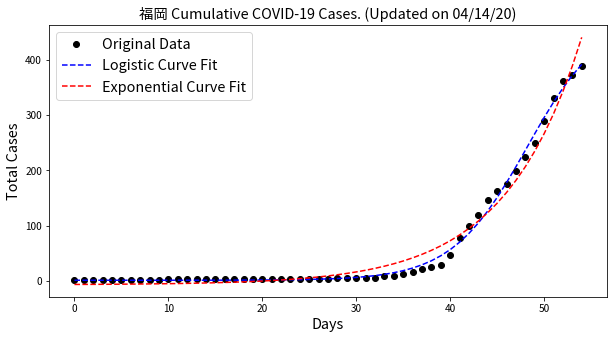



愛知

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 335.0
	Confirmed cases on 04/07/20 	 259.0
	Ratio: 1.29
	Weekly increase: 29.3 %
	Daily increase: 3.7 % per day
	Doubling Time (represents recent growth): 18.9 days

** Based on Logistic Fit**

	R^2: 0.9820479327661495
	Doubling Time (during middle of growth):  40.07 (± 19.87 ) days
	param:  [ 4.08330023e+06  3.46008240e-02 -3.62252310e+01  1.00645971e+08]

** Based on Exponential Fit **

	R^2: 0.9820479340783816
	Doubling Time (represents overall growth):  20.03 (± 1.99 ) days
	param:  [ 2.46483106e+01  3.46007300e-02 -3.62253647e+01]


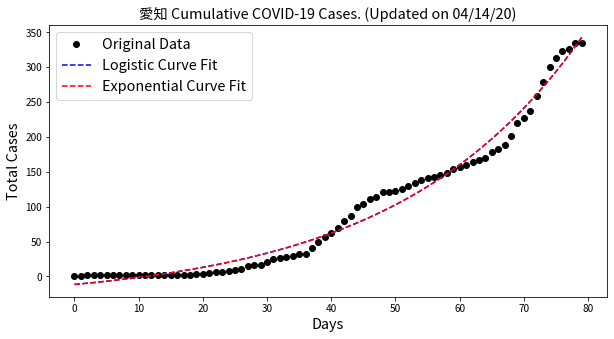



北海道

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 287.0
	Confirmed cases on 04/07/20 	 195.0
	Ratio: 1.47
	Weekly increase: 47.2 %
	Daily increase: 5.7 % per day
	Doubling Time (represents recent growth): 12.6 days

** Based on Logistic Fit**

	R^2: 0.9669172404747641
	Doubling Time (during middle of growth):  21.52 (± 6.09 ) days
	param:  [ 1.86104006e+01  6.44271554e-02 -2.92634984e+01  2.69596536e+02]

** Based on Exponential Fit **

	R^2: 0.9537609852372712
	Doubling Time (represents overall growth):  37.38 (± 10.63 ) days
	param:  [ 8.91699707e+01  1.85434731e-02 -1.00000000e+02]


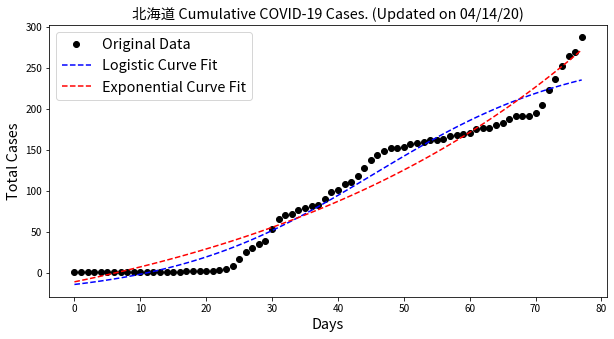



京都

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 208.0
	Confirmed cases on 04/07/20 	 145.0
	Ratio: 1.43
	Weekly increase: 43.4 %
	Daily increase: 5.3 % per day
	Doubling Time (represents recent growth): 13.4 days

** Based on Logistic Fit**

	R^2: 0.994917903507823
	Doubling Time (during middle of growth):  8.4 (± 0.71 ) days
	param:  [7.03703366e+04 1.64956263e-01 3.66320407e+00 2.73129413e+02]

** Based on Exponential Fit **

	R^2: 0.9841543456746138
	Doubling Time (represents overall growth):  8.24 (± 0.53 ) days
	param:  [ 0.42687177  0.08413181 -1.56173783]


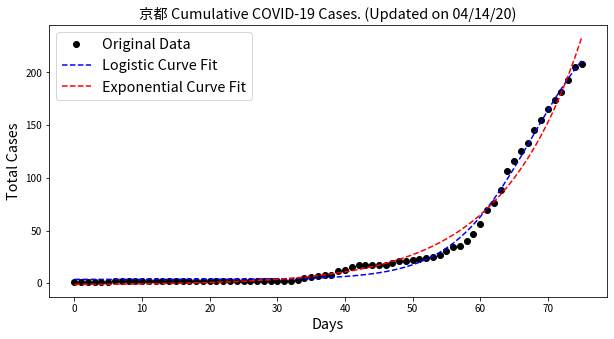



石川

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 131.0
	Confirmed cases on 04/07/20 	 55.0
	Ratio: 2.38
	Weekly increase: 138.2 %
	Daily increase: 13.2 % per day
	Doubling Time (represents recent growth): 5.6 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.9811191231921235
	Doubling Time (represents overall growth):  4.51 (± 0.36 ) days
	param:  [0.04066396 0.15378634 3.82543105]


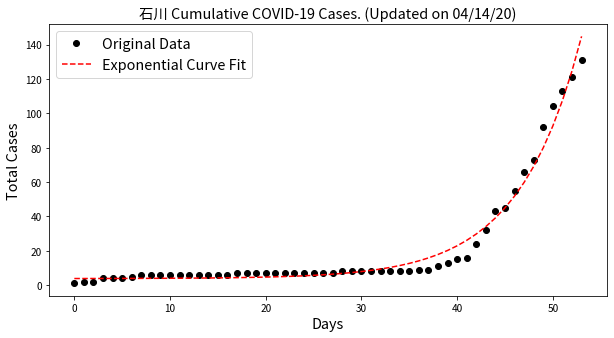



検疫職員

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 131.0
	Confirmed cases on 04/07/20 	 84.0
	Ratio: 1.56
	Weekly increase: 56.0 %
	Daily increase: 6.6 % per day
	Doubling Time (represents recent growth): 10.9 days

** Based on Logistic Fit**

	R^2: 0.9883383906232596
	Doubling Time (during middle of growth):  12.77 (± 2.15 ) days
	param:  [5.90121265e+02 1.08566274e-01 3.88441386e+00 2.24771882e+02]

** Based on Exponential Fit **

	R^2: 0.9845994375849629
	Doubling Time (represents overall growth):  10.26 (± 0.83 ) days
	param:  [ 2.15222661  0.06758264 -0.61726407]


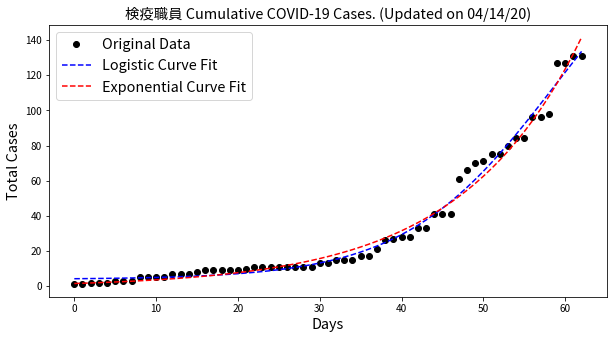



岐阜

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 119.0
	Confirmed cases on 04/07/20 	 69.0
	Ratio: 1.72
	Weekly increase: 72.5 %
	Daily increase: 8.1 % per day
	Doubling Time (represents recent growth): 8.9 days

** Based on Logistic Fit**

	R^2: 0.9978731051934172
	Doubling Time (during middle of growth):  7.06 (± 0.5 ) days
	param:  [4.41246584e+03 1.96222414e-01 1.50156694e+00 1.67715388e+02]

** Based on Exponential Fit **

	R^2: 0.9863754316134556
	Doubling Time (represents overall growth):  6.7 (± 0.54 ) days
	param:  [ 0.95820336  0.10350807 -2.62129407]


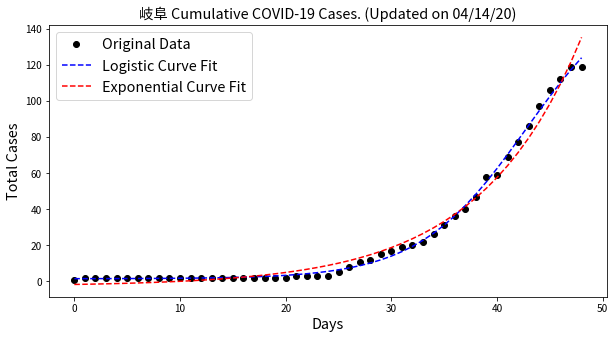



茨城

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 116.0
	Confirmed cases on 04/07/20 	 77.0
	Ratio: 1.51
	Weekly increase: 50.6 %
	Daily increase: 6.0 % per day
	Doubling Time (represents recent growth): 11.8 days

** Based on Logistic Fit**

	R^2: 0.991895514361409
	Doubling Time (during middle of growth):  6.5 (± 1.32 ) days
	param:  [ 64.24065332   0.21328137  -1.40405318 132.55128536]

** Based on Exponential Fit **

	R^2: 0.9789108571314624
	Doubling Time (represents overall growth):  11.66 (± 3.17 ) days
	param:  [ 30.31306555   0.05943788 -35.84605406]


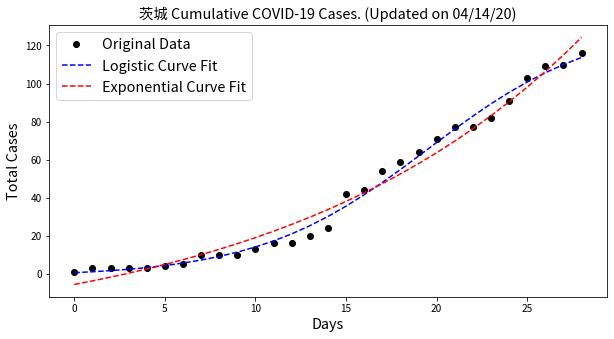



福井

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 92.0
	Confirmed cases on 04/07/20 	 65.0
	Ratio: 1.42
	Weekly increase: 41.5 %
	Daily increase: 5.1 % per day
	Doubling Time (represents recent growth): 14.0 days

** Based on Logistic Fit**

	R^2: 0.9980533548490832
	Doubling Time (during middle of growth):  4.71 (± 0.4 ) days
	param:  [175.27933083   0.29444669  -0.271509    98.37169344]

** Based on Exponential Fit **

	R^2: 0.9685257928366089
	Doubling Time (represents overall growth):  12.43 (± 4.62 ) days
	param:  [ 31.98197772   0.05576043 -39.63550216]


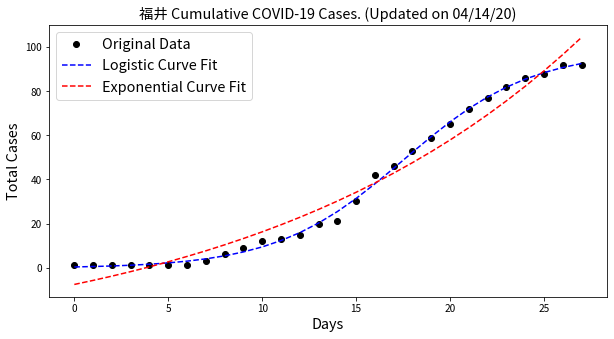



群馬

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 90.0
	Confirmed cases on 04/07/20 	 29.0
	Ratio: 3.1
	Weekly increase: 210.3 %
	Daily increase: 17.6 % per day
	Doubling Time (represents recent growth): 4.3 days

 logistic R^2  0.9309855457744387

 exponential R^2  0.9309855483714093


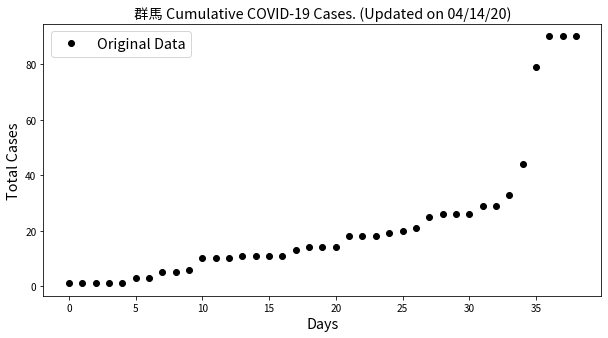



広島

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 87.0
	Confirmed cases on 04/07/20 	 19.0
	Ratio: 4.58
	Weekly increase: 357.9 %
	Daily increase: 24.3 % per day
	Doubling Time (represents recent growth): 3.2 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.9818881009607765
	Doubling Time (represents overall growth):  3.28 (± 0.31 ) days
	param:  [0.02728216 0.21154997 1.55557191]


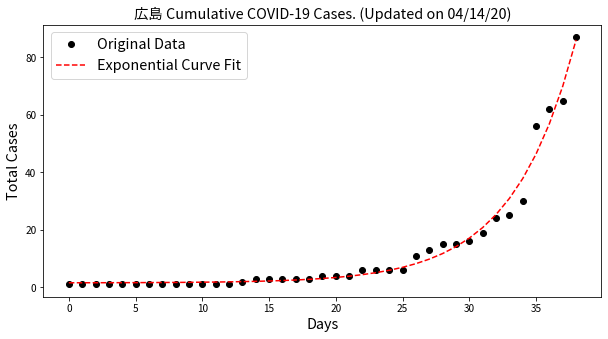



沖縄

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 76.0
	Confirmed cases on 04/07/20 	 33.0
	Ratio: 2.3
	Weekly increase: 130.3 %
	Daily increase: 12.7 % per day
	Doubling Time (represents recent growth): 5.8 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.9860397922964254
	Doubling Time (represents overall growth):  4.3 (± 0.27 ) days
	param:  [0.00511406 0.1612363  2.11329452]


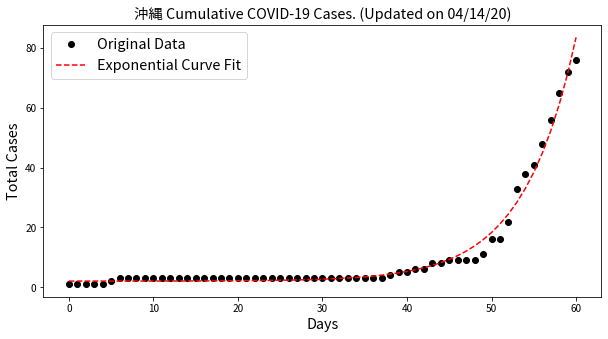



高知

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 60.0
	Confirmed cases on 04/07/20 	 38.0
	Ratio: 1.58
	Weekly increase: 57.9 %
	Daily increase: 6.7 % per day
	Doubling Time (represents recent growth): 10.6 days

** Based on Logistic Fit**

	R^2: 0.9705646945173944
	Doubling Time (during middle of growth):  5.29 (± 1.38 ) days
	param:  [2.36620177e+04 2.61953850e-01 9.53990250e+00 7.21158795e+01]

** Based on Exponential Fit **

	R^2: 0.9565322172350401
	Doubling Time (represents overall growth):  6.53 (± 1.0 ) days
	param:  [0.51656863 0.10620618 6.72696508]


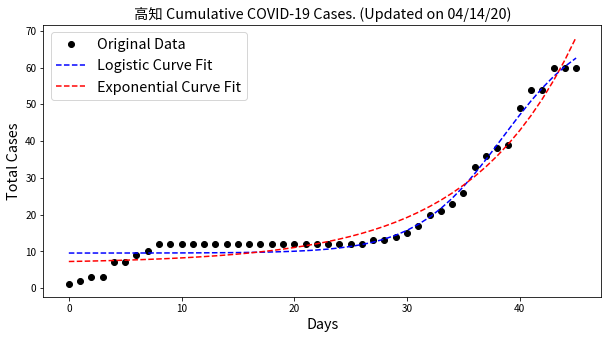



宮城

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 56.0
	Confirmed cases on 04/07/20 	 32.0
	Ratio: 1.75
	Weekly increase: 75.0 %
	Daily increase: 8.3 % per day
	Doubling Time (represents recent growth): 8.7 days

** Based on Logistic Fit**

	R^2: 0.9946637176340368
	Doubling Time (during middle of growth):  5.4 (± 0.6 ) days
	param:  [2.17642377e+04 2.56664918e-01 5.56394370e-01 6.67414522e+01]

** Based on Exponential Fit **

	R^2: 0.9760008293780295
	Doubling Time (represents overall growth):  5.72 (± 0.62 ) days
	param:  [ 0.27325039  0.12110475 -1.09425744]


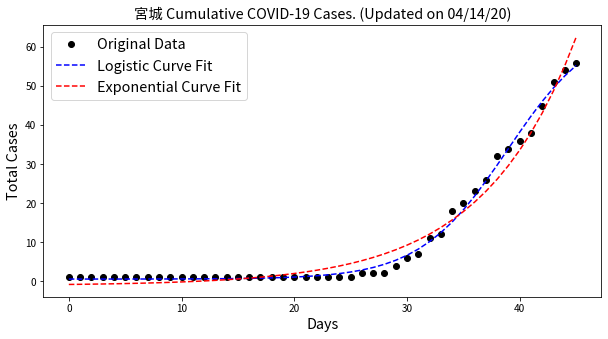



滋賀

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 51.0
	Confirmed cases on 04/07/20 	 24.0
	Ratio: 2.12
	Weekly increase: 112.5 %
	Daily increase: 11.4 % per day
	Doubling Time (represents recent growth): 6.4 days

** Based on Logistic Fit**

	R^2: 0.9847468974076805
	Doubling Time (during middle of growth):  6.8 (± 1.53 ) days
	param:  [1.98002794e+03 2.03801330e-01 1.90625093e+00 7.37289742e+01]

** Based on Exponential Fit **

	R^2: 0.9803509432081348
	Doubling Time (represents overall growth):  5.76 (± 0.62 ) days
	param:  [0.40698732 0.12031568 0.4728957 ]


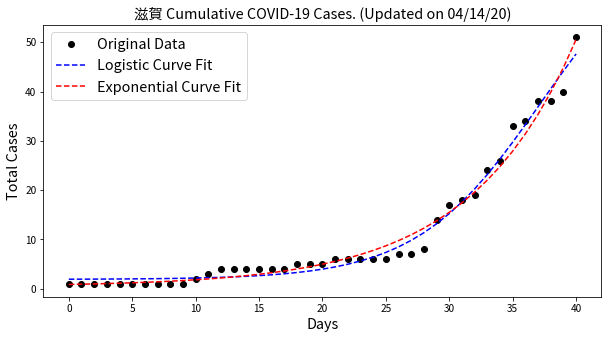



富山

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 49.0
	Confirmed cases on 04/07/20 	 13.0
	Ratio: 3.77
	Weekly increase: 276.9 %
	Daily increase: 20.9 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Logistic Fit**

	R^2: 0.9730226760125431
	Doubling Time (during middle of growth):  3.32 (± 1.85 ) days
	param:  [201.23787583   0.41708084   4.51748112  70.4641246 ]

** Based on Exponential Fit **

	R^2: 0.9668276742436647
	Doubling Time (represents overall growth):  3.9 (± 1.28 ) days
	param:  [ 3.83620073  0.17769544 -1.31113157]


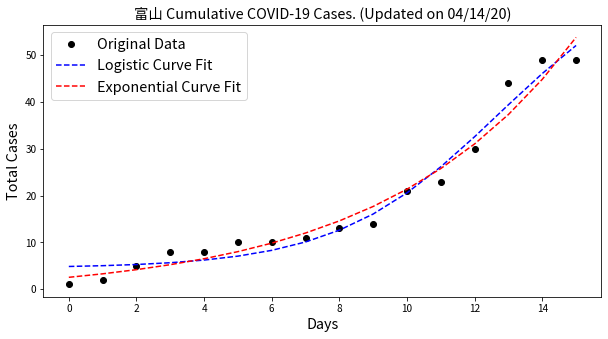



奈良

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 47.0
	Confirmed cases on 04/07/20 	 28.0
	Ratio: 1.68
	Weekly increase: 67.9 %
	Daily increase: 7.7 % per day
	Doubling Time (represents recent growth): 9.4 days

** Based on Logistic Fit**

	R^2: 0.9793357239065471
	Doubling Time (during middle of growth):  17.18 (± 3.8 ) days
	param:  [1.76410599e+09 8.07006587e-02 9.41679357e-01 1.66333461e+08]

** Based on Exponential Fit **

	R^2: 0.9793357248911988
	Doubling Time (represents overall growth):  8.59 (± 0.63 ) days
	param:  [0.09428796 0.08070062 0.94167693]


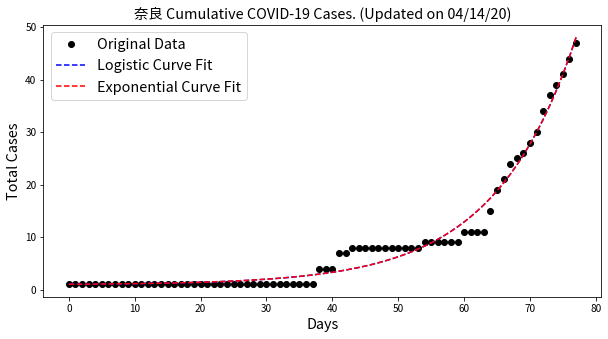



静岡

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 47.0
	Confirmed cases on 04/07/20 	 22.0
	Ratio: 2.14
	Weekly increase: 113.6 %
	Daily increase: 11.5 % per day
	Doubling Time (represents recent growth): 6.4 days

** Based on Logistic Fit**

	R^2: 0.9899000282695428
	Doubling Time (during middle of growth):  6.32 (± 1.0 ) days
	param:  [8.56208214e+03 2.19222841e-01 1.62641307e+00 6.44105515e+01]

** Based on Exponential Fit **

	R^2: 0.9791276734481107
	Doubling Time (represents overall growth):  5.97 (± 0.59 ) days
	param:  [0.24736617 0.11620041 0.24210508]


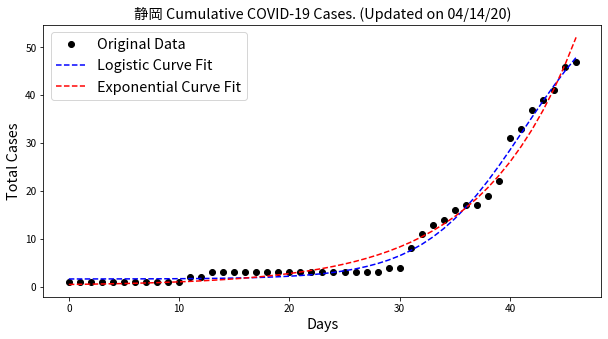



新潟

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 45.0
	Confirmed cases on 04/07/20 	 37.0
	Ratio: 1.22
	Weekly increase: 21.6 %
	Daily increase: 2.8 % per day
	Doubling Time (represents recent growth): 24.8 days

** Based on Logistic Fit**

	R^2: 0.9849637388899353
	Doubling Time (during middle of growth):  27.23 (± 20.13 ) days
	param:  [ 1.43851091e+00  5.09031688e-02 -3.73989544e+01  5.40425485e+01]

** Based on Exponential Fit **

	R^2: 0.9648437260716142
	Doubling Time (represents overall growth):  87.34 (± 106.76 ) days
	param:  [ 1.00000000e+02  7.93655857e-03 -9.63895976e+01]


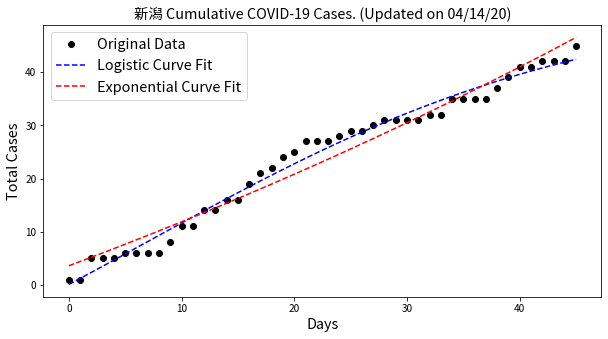



山形

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 43.0
	Confirmed cases on 04/07/20 	 19.0
	Ratio: 2.26
	Weekly increase: 126.3 %
	Daily increase: 12.4 % per day
	Doubling Time (represents recent growth): 5.9 days

** Based on Logistic Fit**

	R^2: 0.9935835698345612
	Doubling Time (during middle of growth):  6.78 (± 4.15 ) days
	param:  [  5.21569749   0.20458546 -10.95799015  58.56631063]

** Based on Exponential Fit **

	R^2: 0.9913382882012819
	Doubling Time (represents overall growth):  26.33 (± 27.7 ) days
	param:  [ 9.96614325e+01  2.63219305e-02 -1.00000000e+02]


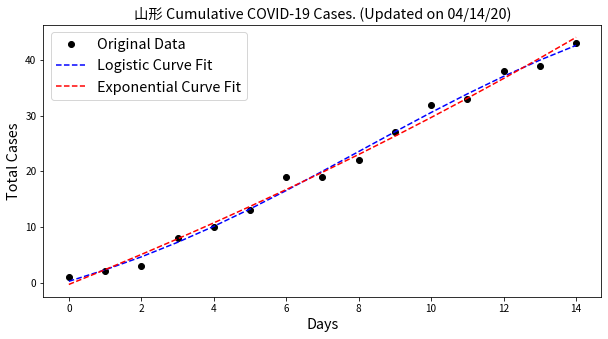



大分

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 43.0
	Confirmed cases on 04/07/20 	 35.0
	Ratio: 1.23
	Weekly increase: 22.9 %
	Daily increase: 3.0 % per day
	Doubling Time (represents recent growth): 23.6 days

** Based on Logistic Fit**

	R^2: 0.9577773210668162
	Doubling Time (during middle of growth):  7.1 (± 2.21 ) days
	param:  [68.79633285  0.19521223 -1.80607174 40.82497215]

 exponential R^2  0.9279665321639015


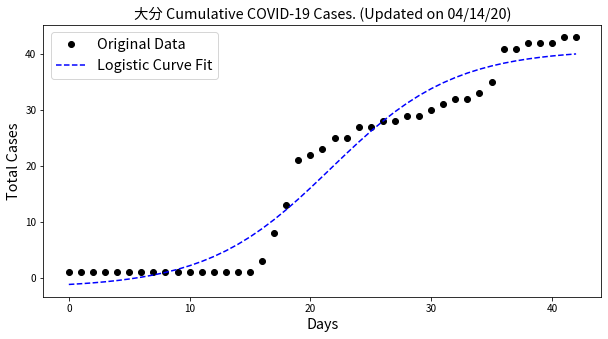



和歌山

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 40.0
	Confirmed cases on 04/07/20 	 31.0
	Ratio: 1.29
	Weekly increase: 29.0 %
	Daily increase: 3.7 % per day
	Doubling Time (represents recent growth): 19.0 days

 logistic R^2  0.9040892226318058

 exponential R^2  0.9040892254392068


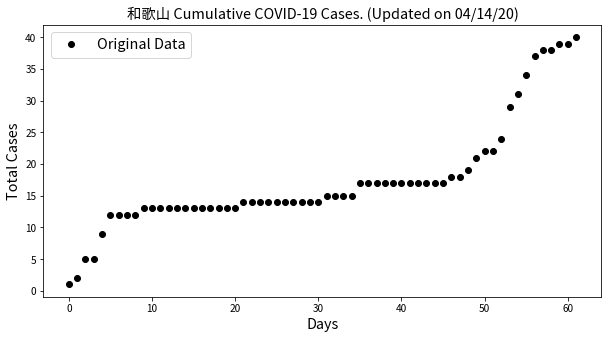



福島

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 39.0
	Confirmed cases on 04/07/20 	 24.0
	Ratio: 1.62
	Weekly increase: 62.5 %
	Daily increase: 7.2 % per day
	Doubling Time (represents recent growth): 10.0 days

** Based on Logistic Fit**

	R^2: 0.994969252002501
	Doubling Time (during middle of growth):  3.14 (± 0.35 ) days
	param:  [6.47081811e+05 4.41787478e-01 1.60905333e+00 4.09267175e+01]

 exponential R^2  0.9402005406791106


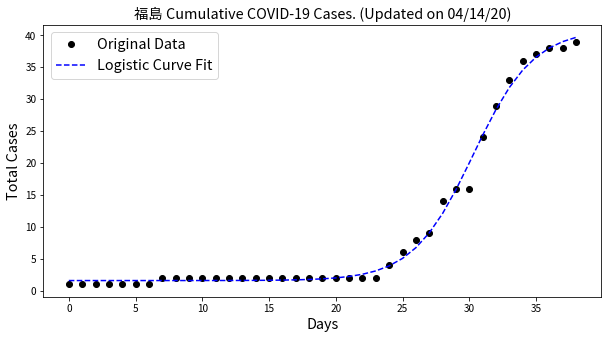



愛媛

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 39.0
	Confirmed cases on 04/07/20 	 23.0
	Ratio: 1.7
	Weekly increase: 69.6 %
	Daily increase: 7.8 % per day
	Doubling Time (represents recent growth): 9.2 days

** Based on Logistic Fit**

	R^2: 0.9795954907857364
	Doubling Time (during middle of growth):  5.26 (± 1.13 ) days
	param:  [8.78467854e+03 2.63503526e-01 1.75097052e+00 3.87695443e+01]

** Based on Exponential Fit **

	R^2: 0.9580812014720683
	Doubling Time (represents overall growth):  7.02 (± 1.14 ) days
	param:  [ 0.5901581   0.09876304 -0.20126361]


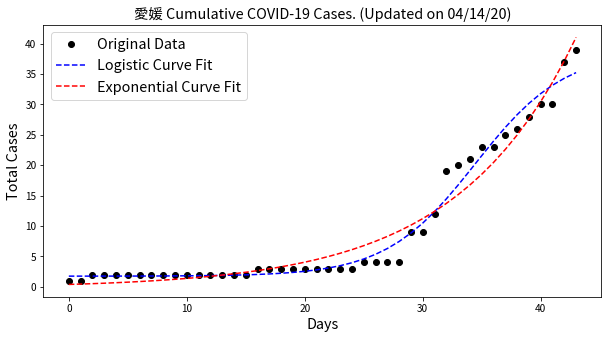



栃木

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 37.0
	Confirmed cases on 04/07/20 	 20.0
	Ratio: 1.85
	Weekly increase: 85.0 %
	Daily increase: 9.2 % per day
	Doubling Time (represents recent growth): 7.9 days

** Based on Logistic Fit**

	R^2: 0.9793914317330248
	Doubling Time (during middle of growth):  12.19 (± 3.31 ) days
	param:  [4.11718357e+02 1.13738793e-01 5.11403301e-01 8.13825709e+01]

** Based on Exponential Fit **

	R^2: 0.9768324240299117
	Doubling Time (represents overall growth):  8.73 (± 0.96 ) days
	param:  [ 0.6596356   0.07940752 -0.5259007 ]


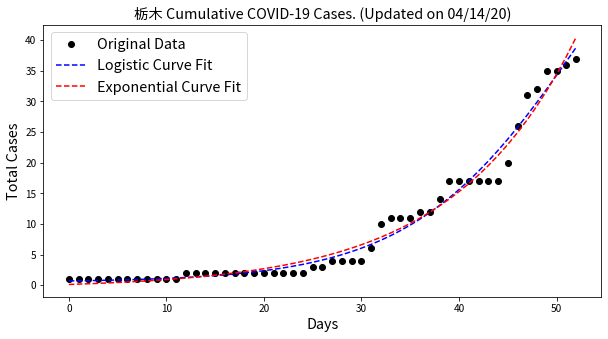



長野

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 37.0
	Confirmed cases on 04/07/20 	 14.0
	Ratio: 2.64
	Weekly increase: 164.3 %
	Daily increase: 14.9 % per day
	Doubling Time (represents recent growth): 5.0 days

** Based on Logistic Fit**

	R^2: 0.9873507067207279
	Doubling Time (during middle of growth):  9.65 (± 2.14 ) days
	param:  [8.63567301e+03 1.43698829e-01 2.51213330e+00 3.11445487e+02]

** Based on Exponential Fit **

	R^2: 0.987263922435151
	Doubling Time (represents overall growth):  5.18 (± 0.37 ) days
	param:  [0.05168954 0.13385957 2.4046366 ]


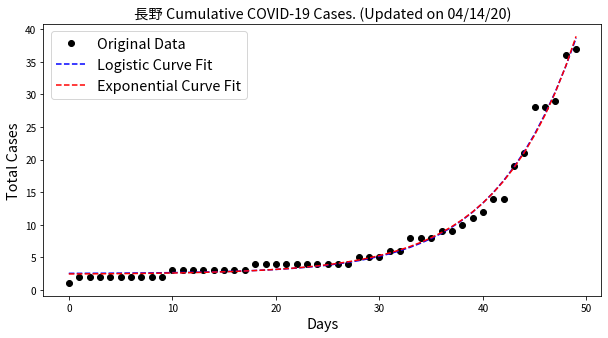



山梨

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 36.0
	Confirmed cases on 04/07/20 	 22.0
	Ratio: 1.64
	Weekly increase: 63.6 %
	Daily increase: 7.3 % per day
	Doubling Time (represents recent growth): 9.9 days

** Based on Logistic Fit**

	R^2: 0.9966879490415245
	Doubling Time (during middle of growth):  4.55 (± 0.41 ) days
	param:  [1.75015103e+04 3.04624087e-01 2.07307756e+00 4.14310890e+01]

** Based on Exponential Fit **

	R^2: 0.9701924991018082
	Doubling Time (represents overall growth):  6.13 (± 0.86 ) days
	param:  [ 0.51017035  0.11309198 -0.01193833]


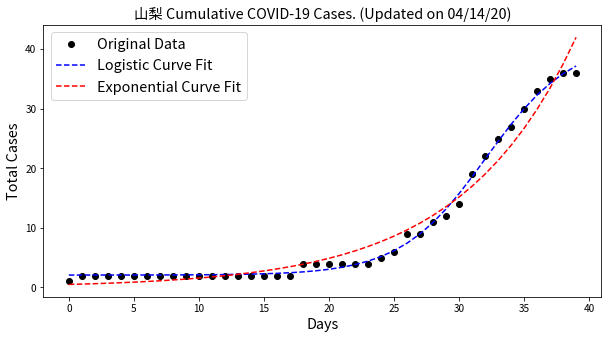



熊本

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 30.0
	Confirmed cases on 04/07/20 	 21.0
	Ratio: 1.43
	Weekly increase: 42.9 %
	Daily increase: 5.2 % per day
	Doubling Time (represents recent growth): 13.6 days

** Based on Logistic Fit**

	R^2: 0.9847634940590299
	Doubling Time (during middle of growth):  9.98 (± 1.94 ) days
	param:  [6.67791989e+02 1.38923222e-01 4.59531851e+00 3.94234563e+01]

** Based on Exponential Fit **

	R^2: 0.9789104044866913
	Doubling Time (represents overall growth):  9.49 (± 1.01 ) days
	param:  [0.57728325 0.07303433 3.30260446]


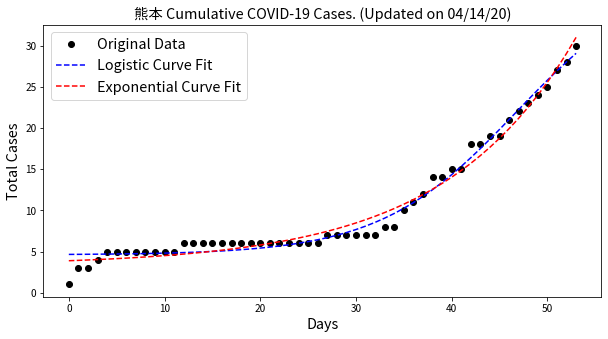



山口

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 24.0
	Confirmed cases on 04/07/20 	 16.0
	Ratio: 1.5
	Weekly increase: 50.0 %
	Daily increase: 6.0 % per day
	Doubling Time (represents recent growth): 12.0 days

** Based on Logistic Fit**

	R^2: 0.979199060635886
	Doubling Time (during middle of growth):  6.33 (± 1.56 ) days
	param:  [2.90172183e+03 2.19058137e-01 2.98595520e+00 3.26494073e+01]

** Based on Exponential Fit **

	R^2: 0.9707620863620005
	Doubling Time (represents overall growth):  6.19 (± 0.82 ) days
	param:  [0.24655568 0.11206868 2.06934777]


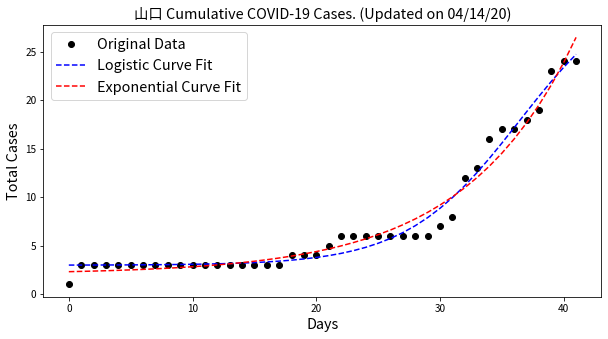



青森

** Based on Most Recent Week of Data **

	Confirmed cases on 04/14/20 	 22.0
	Confirmed cases on 04/07/20 	 12.0
	Ratio: 1.83
	Weekly increase: 83.3 %
	Daily increase: 9.0 % per day
	Doubling Time (represents recent growth): 8.0 days

 logistic R^2  0.9416550702297847

 exponential R^2  0.9416550712209938


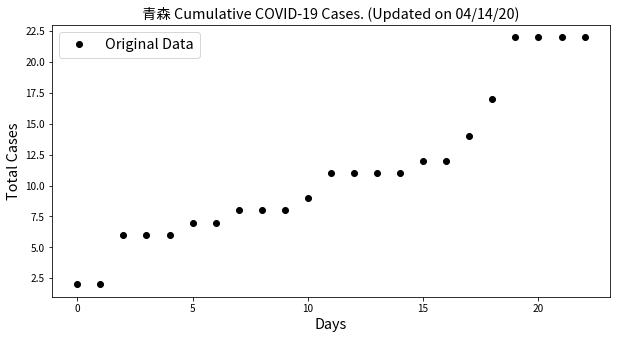

In [8]:
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

cnames = topcountries.values

for c in cnames:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for Global COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


    Inferred Doubling Time  95%CI  Recent Doubling Time
0                      7.7    0.2                   8.2
1                      8.9    0.4                   7.3
2                      8.1    0.4                   8.8
3                      3.2    0.3                   NaN
4                      7.1    0.3                   7.0
5                      7.6    0.4                   8.9
6                      6.6    0.4                   6.9
7                     11.5    1.9                   8.6
8                      5.6    0.5                   7.2
9                     20.0    2.0                  18.9
10                    21.5    6.1                  12.6
11                     8.4    0.7                  13.4
12                     4.5    0.4                   5.6
13      

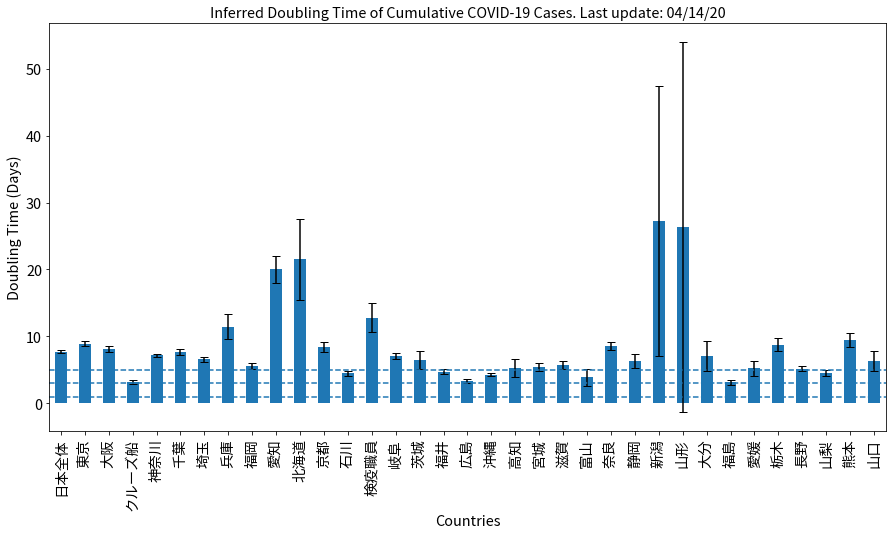

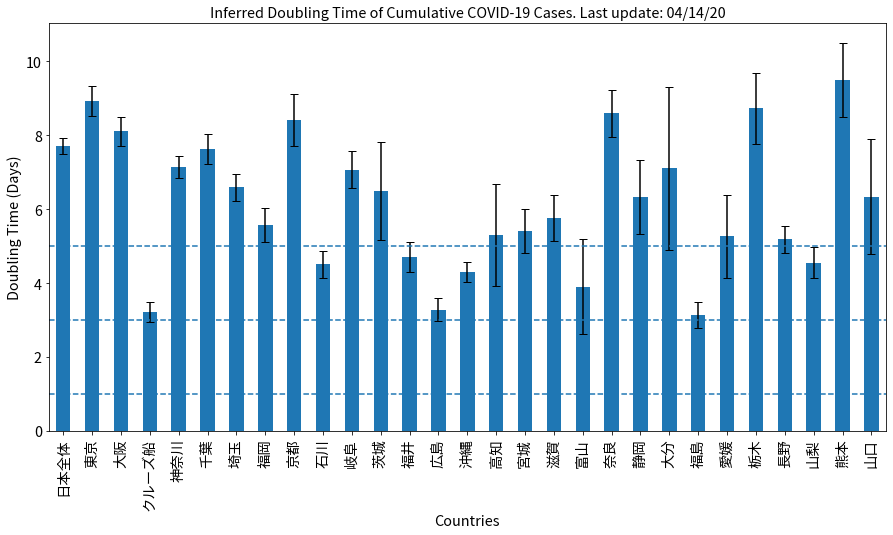

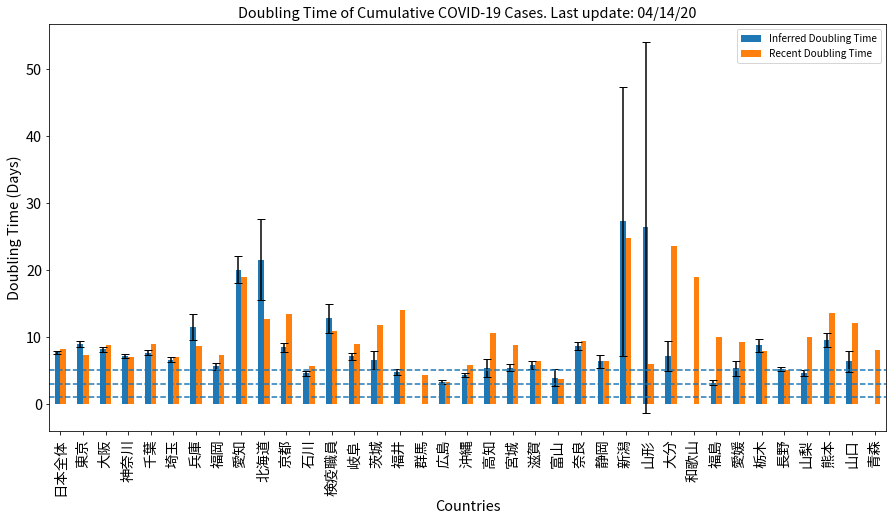

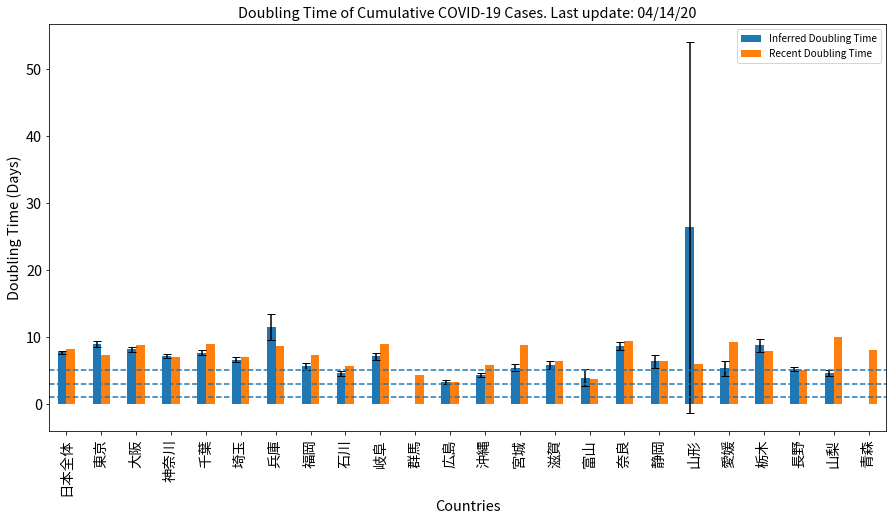

In [9]:
d = {'Countries': countries, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')

print(pd.DataFrame(data=d).iloc[:,[1,2,3]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 10]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=countries
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 10]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()